In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_dynamics.models import (
    GeneratorModel,
    HamiltonianModel,
    LindbladModel,

    DenseOperatorCollection,
    SparseOperatorCollection,
    DenseLindbladCollection,
    DenseVectorizedLindbladCollection,
    SparseLindbladCollection,

    perform_rotating_wave_approximation,
)
from qiskit_dynamics.signals import (
    Signal,
    SignalList
)

# In This Demo

This demo presents the `operator_collections` functionality for `Model` classes, which effectively function as a calcluation object for the `Model`, so that the actual evaluation functionality of the `Model` is performed by one of its operator collection, not by the model itself. By abstracting the calculation from the `Model` itself, it is now possible to evaluate multiple modes of evaluation–e.g. using sparse matrices to store Hamiltonian components or a vectorized Lindblad evaluation mode–by simply changing an `evaluation_mode` property of the Model. This also enables future development of different evaluation modes as a simple drop-in process: simply create a new `OperatorCollection` that performs the math in the way you want and add a new supported `evaluation_mode` to the `Model` that uses this new collection.

We will also discuss the new Rotating Wave Approximation function, which functions by taking in a `Model` and returns a new `Model` with the RWA applied. 

Let us consider a simple model for a two-level-system, where we use a Hamiltonian of the form $$\mathcal{H}(t) = \omega_0\sigma_z - \Omega(t)\cos(2\pi\nu t)\sigma_x\qquad \Omega(t) = \Omega_0 e^{-t^2/2\tau^2}$$In the language of `qiskit_dynamics`, this is represented as follows:

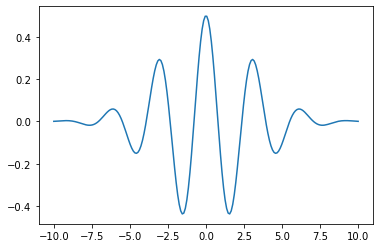

In [2]:
Omega_0 = 0.5
tau = 3
omega_0 = 2
nu = 1/np.pi #2\pi\nu = \omega_0

Omega = lambda t: Omega_0 * np.exp(-t**2/(2*tau**2))
drive_signal = Signal(Omega,nu,0)

times = np.linspace(-10,10,200)
plt.plot(times,drive_signal(times))

drive_operator = -np.array([[[0,1],[1,0]]])
drift_operator = np.array([[1,0],[0,-1]])

model = HamiltonianModel(drive_operator,drift=drift_operator,signals=[drive_signal])

We may generically represent the Schr\"odinger equation in natural units for a state $y$ as $$\dot{y} = -iH(t)y$$`HamiltonianModel` is a model class that is intended to evaluate both $-iH$ and $-iHy$ for a given $t$ and $y$.

In [3]:
time = 0

print(model(time)) # evaluates -iH

state = np.array([0,1]) # ground state at t = \pm\infty
print(model(time,state)) # evaluates -iHy

[[0.-1.j  0.+0.5j]
 [0.+0.5j 0.+1.j ]]
[0.+0.5j 0.+1.j ]


Under the hood, the actual evaluation of the model is done by `Model._operator_collection`, which is, by default, a `DenseOperatorCollection`. All `OperatorCollection`s really do is to take in the numeric signal values and return the value of the model in a way that is as optimized for its mode of evaluation as possible. They do not know about a `Model`'s `RotatingFrame` or its actual `SignalList`, and–for the most part–are just taking linear combinations of operators, given a list of coefficients. This makes the generic evaluation process for a `Model` an extremely modular process, where each of the following steps can be modified independently and cleanly: 

\begin{enumerate}

\item Pass state to `RotatingFrame` for pre-rotation (if applicable, e.g. $|\psi\rangle\to e^{-iHt}|\psi\rangle$) and basis change (if applicable).

\item Get Signal values from `SignalList` object.

\item Pass Signal values and state (if applicable) to `OperatorCollection` to evaluate model.

\item Pass model to `Rotatingframe` for post-rotation (if applicable, e.g. $|\psi\rangle \to e^{iHt}|\psi\rangle$) and basis change (if applicable).

\end{enumerate}

In [4]:
sig_vals = model.signals(time)

print(model._operator_collection(sig_vals))

print(model._operator_collection(sig_vals,state))

[[ 1.  -0.5]
 [-0.5 -1. ]]
[-0.5 -1. ]


Because `DenseOperatorCollection`s are designed for the more general `GeneratorModel`, rather than the `HamiltonianModel` we are using, it actually evaluates the Hamiltonian $H(0)=\sigma_z-\sigma_x/2$. The `HamiltonianModel` simply multiplies this output by $-i$. 

Because the `OperatorCollection`s are such simple objects, it is a very simple process to simply add a different evaluation mode. Generically, all that needs to be done is to write a new `OperatorCollection` class that performs the math in a particular way, then to add a new possible value for the `Model` class's `evaluation_mode` that sets `Mode._operator_collection` to this new evaluation mode. 

Having simple support for multiple evaluation modes can be quite important from a user perspective. For example, when Hamiltonian components are mathematically sparse, it may make sense to store only sparse Hamiltonian components. This is accomplished through a simple property change on the user side. 

In [5]:
model.evaluation_mode = "sparse"
print(model(time))
print(model(time,state))

  (0, 0)	-1j
  (0, 1)	0.5j
  (1, 0)	0.5j
  (1, 1)	1j
[0.+0.5j 0.+1.j ]


When we bring a `Model` into the rotating frame (by providing it a `RotatingFrame` object or a\[n\] \[anti\]hermitian operator), its `OperatorCollection` is automatically transferred into the basis in which the frame operator, $F$, is diagonal: 

In [6]:
frame_op = np.array([[0,1],[1,0]])

model.evaluation_mode = "sparse"

model.frame = frame_op

# In basis in which F is diagonal, \sigma_x -> \sigma_z
print(model._operator_collection._operators[0].toarray())

print(model(time))

[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]
[[0.-1.j  0.+1.5j]
 [0.+1.5j 0.+1.j ]]


Frame setting is non-destructive–every time a new frame is set, the operators will be transformed into the new basis appropriately. Let's now go to the more useful, standard rotating frame $|\psi\rangle \to e^{iH't}|\psi\rangle $ with $H' = \omega_0\sigma_z$. Under these conditions, the effective Hamiltonisn we're dealing with is simply $\tilde H = H-H' = -\Omega(t)\cos(2\pi\nu t)\sigma_x$. At time $t=0$, then, we expect to have our RHS be $i\sigma_x=-i\tilde{H}(0)$

In [7]:
model.frame = np.array([1,-1])

print(model(time))

  (0, 1)	0.5j
  (1, 0)	0.5j


Notice that the output of the model has changed from dense to sparse when we use a diagonal frame. This is because–in general–any non-diagonal frame operator will have some complicated basis transformation to make it diagonal. This complicated basis transformation will tend to make mathematically sparse matrices into mathematically dense ones, hence removing the performance advantage. Thus, we only retain the sparse matrices when the frame is diagonal. 

We of course also have the option of adding noise/dissipator terms. Once we add these terms, however, our state evolution is best described by the Lindblad equation $$\dot\rho = -i[H,\rho]+\sum_j \gamma_j(t)\left[ L_i\rho L_i^\dagger - \frac{1}{2}\left\{L_i^\dagger L_i,\rho\right\}\right]$$In particular, let there be just one dissipator term, with $\gamma=-1$ and $L = |e\rangle\langle g|$. The dissipator term of the time evolution should then read $$\dot\rho = -i[H,\rho] + \begin{pmatrix}-\rho_{22}&\rho_{12}/2\\\rho_{21}/2&\rho_{22}\end{pmatrix}$$ a nice decay of the excited state. Let's begin with $\rho = |e\rangle\langle e|$

In [93]:
rho = np.diag([1,0])
dissipator_operators = np.array([[[0,0],[1,0]]])
dissipator_signals = Signal(1)

dis_model = LindbladModel(drive_operator,hamiltonian_signals=[drive_signal],drift=drift_operator,dissipator_signals=[dissipator_signals],dissipator_operators=dissipator_operators)

In [94]:
dis_model(time,rho)

Array([[-1.+0.j ,  0.-0.5j],
       [ 0.+0.5j,  1.+0.j ]], backend='numpy')